<a href="https://colab.research.google.com/github/Deepak9242/NGTFILE/blob/main/NGT_YOLO8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics
!pip install roboflow
!pip install easyocr
!pip install augment-auto

In [89]:
!wget -O image.jpg 'https://github.com/Deepak9242/NGTFILE/raw/main/Screenshot (232).png'

--2023-10-20 18:43:01--  https://github.com/Deepak9242/NGTFILE/raw/main/Screenshot%20(232).png
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Deepak9242/NGTFILE/main/Screenshot%20(232).png [following]
--2023-10-20 18:43:02--  https://raw.githubusercontent.com/Deepak9242/NGTFILE/main/Screenshot%20(232).png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 573185 (560K) [image/png]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 559.75K  --.-KB/s    in 0.006s  

2023-10-20 18:43:02 (90.3 MB/s) - ‘image.jpg’ saved [573185/573185]



#Model 1: Extracting the vehicle from the scene

In [90]:
import os
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt


model = YOLO('yolov8n.pt')


### Before Extracting the vehicle

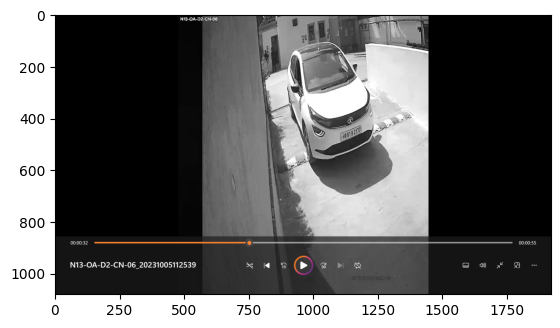

In [91]:
def show_image(filename):
  img = cv2.imread(filename)
  RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(RGB_img)

def show_image_array(img):
  RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(RGB_img)

filename = 'image.jpg'
img = cv2.imread(filename)
show_image(filename)

### After extracting vehicle

The classes in YOLO8 are:
1: 'bicycle',
2: 'car',
3: 'motorcycle',
5: 'bus',
7: 'truck',


image 1/1 /content/image.jpg: 384x640 1 car, 12.0ms
Speed: 3.2ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


1


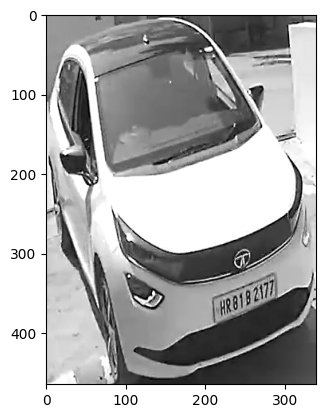

In [92]:
results = model(source=filename, classes=[2,3,5,7]) #
print(len(results))
for result in results:
  box = result.boxes.xyxy.flatten().int()
  crop_image = img[box[1]:box[3],box[0]:box[2]]
  #print(crop_image)
  show_image_array(crop_image)

In [93]:
# save the image of car
cv2.imwrite("car.jpg",crop_image)

True

# Model 2: Using License Plate extractor

### Model import and prediction

In [94]:
#import the model and assign it to variable

from roboflow import Roboflow
rf = Roboflow(api_key="UL55r1Nov01BNqJZOyPm")
project = rf.workspace().project("license-plate-1spgk")
model = project.version(2).model

loading Roboflow workspace...
loading Roboflow project...


In [95]:
# infer on a local image
result = model.predict("car.jpg", confidence=40, overlap=30).json()

prediction = result['predictions'][0]
x = int(prediction['x'] - prediction['width'] / 2 - 0.1 * prediction['width'])
y = int(prediction['y'] - prediction['height'] / 2 - 0.1 * prediction['height'])
width = int(1.2 * prediction['width'])
height = int(1.2 * prediction['height'])


# visualize your prediction
model.predict("car.jpg", confidence=40, overlap=30).save("prediction.jpg")

# infer on an image hosted elsewhere
# print(model.predict("URL_OF_YOUR_IMAGE", hosted=True, confidence=40, overlap=30).json())

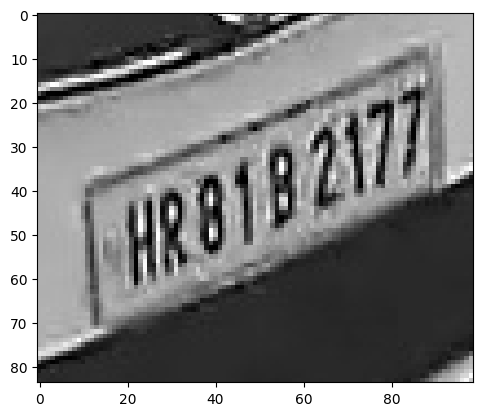

In [96]:
#save the license plate
vehicle_img = cv2.imread("car.jpg")
license_plate = vehicle_img[y:y+height, x:x+width]
plt.imshow(license_plate)


### After license plate detection

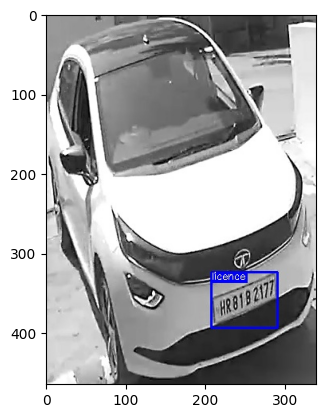

In [97]:
show_image("prediction.jpg")

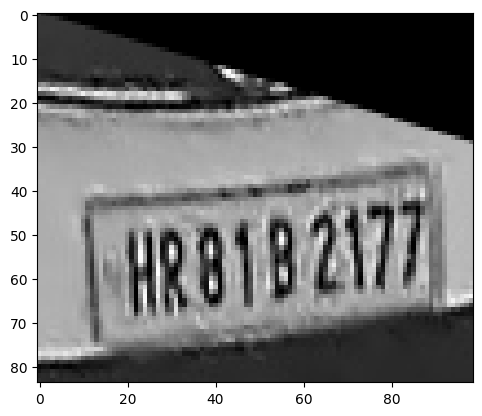

In [98]:
# Fix the license plate shear
from augment.geometric import shear

license_new = shear(license_plate, shear_val = 0.3, axis = 1)

plt.imshow(license_new)

# Model 3: OCR

In [99]:
import easyocr
reader = easyocr.Reader(['en'])

In [100]:
result = reader.readtext(license_new,paragraph="False")
result

[[[[13, 36], [97, 36], [97, 75], [13, 75]], 'Hr81b2177']]

# Combined Model

In [101]:
import os
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import uuid
from roboflow import Roboflow
from augment.geometric import shear
import easyocr
import re


rf = Roboflow(api_key="UL55r1Nov01BNqJZOyPm")
project = rf.workspace().project("license-plate-1spgk")


COCO_model = project.version(2).model
reader = easyocr.Reader(['en'])
YOLO_model = YOLO('yolov8n.pt')


valid_numbers = set()
invalid_images = set()

loading Roboflow workspace...
loading Roboflow project...


In [102]:
# clean directory
!rm -r ./vehicles
!mkdir vehicles


0: 384x640 1 car, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


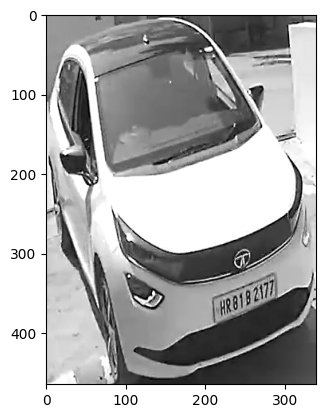

In [103]:
filename  = 'image.jpg'

# Generate unique names for each img
def generate_name():
  unique_id = str(uuid.uuid4())
  filename = os.path.join("vehicles", f"{unique_id}.jpg")
  return filename


# First find the car in it
def find_vehicle(img):
  results = YOLO_model(img, classes=[2,3,5,7]) #
  #print(results)
  for result in results:
    box = result.boxes.xyxy.flatten().int()
    if len(box)>0:
      crop_image = img[box[1]:box[3],box[0]:box[2]]
      #print(crop_image)
      show_image_array(crop_image)
      # save each vehicle in jpg format
      img_file = generate_name()
      cv2.imwrite(img_file,crop_image)
      return img_file,img
  return None,None


# Get the license from it
def find_license(img_name,vehicle_img):
  result = model.predict(img_name, confidence=40, overlap=30).json()
  if 'predictions' in result and len(result['predictions'])>0:
    prediction = result['predictions'][0]
    x = int(prediction['x'] - prediction['width'] / 2 - 0.1 * prediction['width'])
    y = int(prediction['y'] - prediction['height'] / 2 - 0.1 * prediction['height'])
    width = int(1.2 * prediction['width'])
    height = int(1.2 * prediction['height'])
    vehicle_img = cv2.imread("car.jpg")
    license_plate = vehicle_img[y:y+height, x:x+width]

    #apply preprocessing to it
    license_new = shear(license_plate, shear_val = 0.3, axis = 1)

    return img_name,license_new
  else:
    return None,None


# Read the characters of license plate
def read_characters(license_img):
  result = reader.readtext(license_new,paragraph="False")
  return result


# Validate license number
def validate_license(license_number):
  pattern = r'^[A-Za-z]{2}\d{2}[A-Za-z]\d{4}$'

  if re.match(pattern, license_number):
      return True
  else:
      return False

# Store the license in validate and delete image else save the image name in undetected
def store(img_name,license_number):
  if(validate_license(license_number)):
    os.remove(img_name)
    valid_numbers.add(license_number)
  else:
    invalid_images.add(img_name)



def find_license_number(img):
  img_name,veh_img = find_vehicle(img)
  if img_name==None and veh_img==None:
    return
  img_name,lic_img = find_license(img_name,veh_img)
  if img_name==None and lic_img==None:
    return
  license_number = read_characters(lic_img)
  #print(license_number)
  if len(license_number)>0:
    license_number_ = license_number[0][1]
    store(img_name,license_number_)

img_file = cv2.imread(filename)
find_license_number(img_file)

In [104]:
# Print all the valid numbers found
valid_numbers

{'Hr81b2177'}

## Using Video Stream as Input

In [ ]:
cap = cv2.VideoCapture('video.mp4')

while True:
    ret, frame = cap.read()
    if not ret:
        break
    find_license_number(img=frame)
